## If in Colab

In [1]:
in_colab = False
floatType = 32
last_data_idx = -1

In [2]:
import tensorflow as tf
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
if floatType == 16:
    tf.keras.backend.set_floatx('float16')

In [3]:
if in_colab:
    import sys
    data_dir = "/content/drive/MyDrive/data/"
    VOC2012_path = data_dir
    tracker_path = data_dir
    sys.path.append(tracker_path)
    ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
    checkpoint_filepath = data_dir + "weights/"
else:
    data_dir = "../data/"
    VOC2012_path = data_dir + "VOCdevkit/"
    tracker_path = "../Tracking_SSD_ReID/"
    ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
    checkpoint_filepath = data_dir + "segmentation_weights/"

## Import model

In [4]:
from models.FCN8 import FCN8
model = FCN8(tracker_ssd_path = tracker_path, 
             ssd_weights_path = ssd_weights_path,
             floatType = floatType,
             n_classes = 3)

## Prepare VOC2012 segmentation data

  0%|▎                                                                              | 13/2912 [00:00<00:23, 123.32it/s]


Loading images and annotations...


100%|█████████████████████████████████████████████████████████████████████████████| 2912/2912 [00:16<00:00, 174.83it/s]



Convert to tensor...

Done
Images shape: (2912, 300, 300, 3), annotations shape: (2912, 300, 300, 1)


  0%|▎                                                                              | 11/2912 [00:00<00:26, 108.60it/s]

Reshape gt from (300, 300, 1) to (300, 300, n_classes)


100%|█████████████████████████████████████████████████████████████████████████████| 2912/2912 [00:25<00:00, 115.92it/s]


Images shape: (2912, 300, 300, 3), annotations shape: (2912, 300, 300, 21)
Examples:


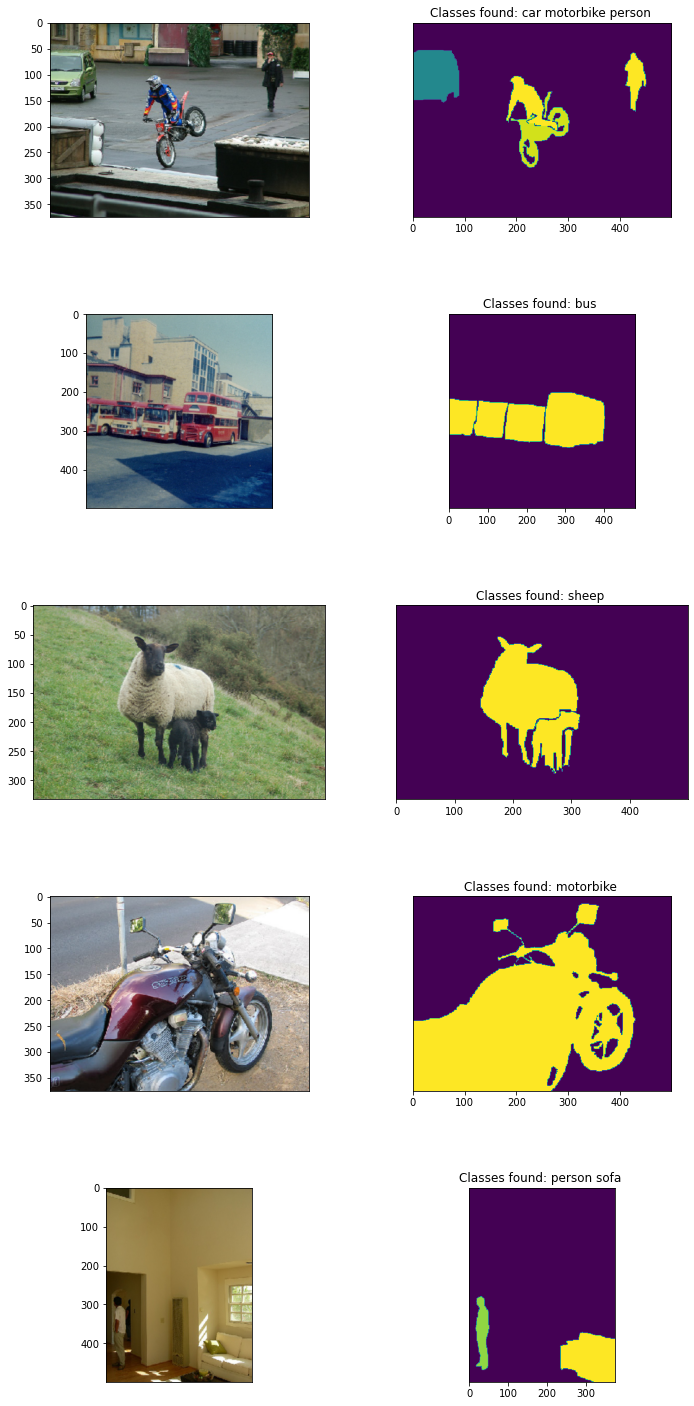

In [4]:
from data_management.VOC2012Manager import VOC2012Manager

manager = VOC2012Manager(floatType = floatType)
targets = None
images, gt_annotations, filenames_png, original_shapes =\
    manager.load_and_prepare_data(
        VOC2012_path=VOC2012_path,
        width_height=(300, 300,),
        n_samples_to_show=5,
        targets=targets,
        last_data_idx=last_data_idx)

In [6]:
train_ratio = 0.7
batch_size = 32
train_dataset, val_dataset = manager.tensorf2TFData(images, gt_annotations, train_ratio, batch_size)

In [7]:
# # verify train val shapes
# for train_img, train_annot in train_dataset:
#     break
# for val_img, val_annot in val_dataset:
#     break
# print(f"Train images shape: {train_img.shape}, train annotations shape: {train_annot.shape}")
# print(f"Val images shape: {val_img.shape}, Val annotations shape: {val_annot.shape}")

## Train model

In [8]:
sgd = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [9]:
# number of training images
train_count = images.shape[0] * train_ratio

# number of validation images
validation_count = images.shape[0] * (1 - train_ratio)

epochs = 10

steps_per_epoch = train_count//batch_size
validation_steps = validation_count//batch_size

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                    #validation_data=val_dataset, validation_steps=validation_steps,
                    epochs=epochs, callbacks=[model_checkpoint_callback])

In [ ]:
model.save(checkpoint_filepath)